In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import numpy as np
import shutil
import zipfile
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from collections import Counter
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
project_path = '/content/drive/MyDrive/Master/Dizertatie'
os.chdir(project_path)

print("Current directory:", os.getcwd())


Current directory: /content/drive/MyDrive/Master/Dizertatie


In [4]:
sys.path.append(os.path.join(project_path, 'utils'))

In [5]:
dataset_folder = '/content/drive/MyDrive/Master/Dizertatie/BCN20000'
os.listdir(dataset_folder)

['bcn20000_metadata_2024-12-04.csv',
 'ISIC-images',
 '.ipynb_checkpoints',
 'split-dataset',
 'resized-images',
 'augmented-train-images-aug2',
 'augmented_train_images_aug3',
 'resized-images-224',
 'augmented-train-images-aug4',
 'split-dataset-224',
 'train',
 'no-background']

In [6]:
from importlib import reload
import plots
reload(plots)
import preprocessing
reload(preprocessing)
import data_augmentation
reload(data_augmentation)
import model
reload(model)


<module 'model' from '/content/drive/MyDrive/Master/Dizertatie/utils/model.py'>

In [7]:
from plots import (
    plot_class_distribution,
    plot_diagnosis_distribution,
    plot_age_distribution,
    plot_gender_proportion,
    plot_anatomical_site_distribution,
    plot_example_images_per_class
)
from preprocessing import (
    crop_and_save_image,
    crop_images_in_folder,
    resize_images,
    split_train_test
)
from data_augmentation import (
    augment_images
)
from model import (
    create_feature_vector,
    process_images,
    create_efficientnet,
    create_metadata_network,
    create_combined_model,
    train_model
)

In [8]:
train_zip_path = "/content/drive/MyDrive/Master/Dizertatie/cropped-augmented-train-224.zip"
test_zip_path = "/content/drive/MyDrive/Master/Dizertatie/cropped-test-224.zip"
metadata_path = "/content/drive/MyDrive/Master/Dizertatie/BCN20000/bcn20000_metadata_2024-12-04.csv"
base_model_path = '/content/drive/MyDrive/Master/Dizertatie/model-cropped-224.h5'
save_model_path = '/content/drive/MyDrive/Master/Dizertatie/model-cropped-224-metadata-weights.weights.h5'
input_size = (224, 224)
input_size_image = (224, 224, 3)

local_train_zip_path = "/content/dataset.zip"
local_test_zip_path = "/content/test.zip"
local_metadata_path = "/content/metadata.csv"

shutil.copy(train_zip_path, local_train_zip_path)
shutil.copy(test_zip_path, local_test_zip_path)
shutil.copy(metadata_path, local_metadata_path)
print(f"The file was copied locally: {local_train_zip_path}")
print(f"The file was copied locally: {local_test_zip_path}")
print(f"The file was copied locally: {local_metadata_path}")


The file was copied locally: /content/dataset.zip
The file was copied locally: /content/test.zip
The file was copied locally: /content/metadata.csv


In [9]:
extract_folder_train = "/content/dataset/"
extract_folder_test = "/content/test/"

os.makedirs(extract_folder_train, exist_ok=True)
os.makedirs(extract_folder_test, exist_ok=True)

with zipfile.ZipFile(local_train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_train)
with zipfile.ZipFile(local_test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_test)

print(f"Files were added to: {extract_folder_train}")
print(f"Files were added to: {extract_folder_test}")


Files were added to: /content/dataset/
Files were added to: /content/test/


In [13]:
train_image_folder = extract_folder_train + 'cropped-augmented-train-224/'
test_image_folder = extract_folder_test + 'cropped-test-224/'

In [ ]:
def create_metadata_dict(metadata, image_folder):
    """
    Creates a dictionary mapping image filenames to metadata feature vectors.

    - One-hot encodes `anatom_site_general` (6 categories)
    - One-hot encodes `sex` (2 categories: male, female)
    - Uses numerical encoding for `age_approx` with missing values set to -5.

    Parameters:
    - metadata (pd.DataFrame): DataFrame containing 'isic_id', 'age_approx', 'anatom_site_general', 'sex'.
    - image_folder (str): Path to the folder containing images.

    Returns:
    - dict: Mapping of {filename: feature_vector}.
    """
    metadata['age_approx'].fillna(-5, inplace=True)

    anatomical_sites = ["anterior torso", "lower extremity", "upper extremity",
                        "head/neck", "palms/soles", "oral/genital"]
    anatomical_one_hot = pd.get_dummies(metadata['anatom_site_general'], columns=anatomical_sites)

    sex_categories = ["male", "female"]
    sex_one_hot = pd.get_dummies(metadata['sex'], columns=sex_categories)

    metadata_encoded = pd.concat([metadata[['isic_id', 'age_approx']], anatomical_one_hot, sex_one_hot], axis=1)

    metadata_dict = {}
    for file in os.listdir(image_folder):
        if file.endswith(".jpg"):
            isic_id = file.split('.')[0]  # Extract ISIC ID from filename
            meta_row = metadata_encoded[metadata_encoded['isic_id'] == isic_id]

            if not meta_row.empty:
                feature_vector = meta_row.drop(columns=['isic_id']).values[0].astype(np.float32)
                metadata_dict[file] = feature_vector

    return metadata_dict


def create_image_metadata_generator(image_folder, metadata_dict, label_dict, num_classes, batch_size=32, target_size=(224, 224)):
    """
    Creates a generator that yields image data, metadata features, and labels.

    Parameters:
    - image_folder (str): Path to the folder containing images.
    - metadata_dict (dict): Precomputed dictionary with metadata features.
    - label_dict (dict): Dictionary mapping image filenames to class labels.
    - num_classes (int): Number of output classes.
    - batch_size (int): Batch size for training.
    - target_size (tuple): Target image size (default: 224x224).

    Yields:
    - images (np.array): Image batch.
    - metadata_features (np.array): Corresponding metadata batch.
    - labels (np.array): One-hot encoded labels.
    """
    image_files = [f for f in os.listdir(image_folder) if f in label_dict and f in metadata_dict]

    while True:
        random.shuffle(image_files)  

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            images, metadata_features, labels = [], [], []

            for file in batch_files:
                img_path = os.path.join(image_folder, file)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img).astype('float32') / 255.0  # Normalize image

                meta_features = metadata_dict[file]

                images.append(img_array)
                metadata_features.append(meta_features)
                labels.append(label_dict[file])

            images = np.array(images)
            metadata_features = np.array(metadata_features, dtype=np.float32)
            labels = to_categorical(labels, num_classes=num_classes)

            yield {"input_layer": images, "metadata_input": metadata_features}, labels


def create_label_dict(metadata, diagnosis_mapping, image_folder):
    """
    Creates a dictionary mapping image filenames to labels

    Parameters:
    - metadata (pd.DataFrame):DataFrame containing 'isic_id' and 'diagnosis'.
    - diagnosis_mapping (dict): dictionary with the diagnosis
    - image_folder (str): Path to the folder containing images.

    Returns:
    - dict: Mapping of {filename: class}
    """
    label_dict = {}

    for file in os.listdir(image_folder):
        if file.endswith(".jpg"):
            isic_id = file[:12]
            diagnosis = metadata.loc[metadata['isic_id'] == isic_id, 'diagnosis']

            if not diagnosis.empty:
                label_dict[file] = diagnosis_mapping[diagnosis.values[0]]

    return label_dict


def create_diagnosis_mapping(metadata):
    """
    Creates a mapping from diagnosis to numerical labels.

    Parameters:
    - metadata (pd.DataFrame): Metadata DataFrame containing 'diagnosis'.

    Returns:
    - dict: Mapping of diagnosis to numerical labels.
    """
    return {diag: idx for idx, diag in enumerate(metadata['diagnosis'].unique())}


def calculate_class_distribution(metadata, folder, diagnosis_mapping):
    """
    Calculates the class distribution in the training dataset.

    Parameters:
    - metadata (pd.DataFrame): Metadata DataFrame containing 'isic_id' and 'diagnosis'.
    - folder: Name of folder with the location of the images
    - diagnosis_mapping (dict): Mapping of diagnosis to numerical labels.

    Returns:
    - dict: Class distribution in the dataset.
    """
    image_ids = [os.path.splitext(f)[0] for f in os.listdir(folder) if f.endswith('.jpg')]
    prefixes = [img_id[:12] for img_id in image_ids]

    labels = []
    for prefix in prefixes:
        diagnosis = metadata.loc[metadata['isic_id'] == prefix, 'diagnosis'].map(diagnosis_mapping).values
        if len(diagnosis) > 0:
            labels.append(diagnosis[0])

    return Counter(labels)

def sensitivity(y_true, y_pred):
    """Computes sensitivity (recall) for multi-class classification"""
    y_true = K.cast(y_true, dtype='float32')  # Ensure consistent data type
    y_pred = K.cast(y_pred, dtype='float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    return true_positives / (possible_positives + K.epsilon())

In [15]:
# Load metadata
metadata = pd.read_csv(metadata_path)

# Create diagnosis mapping
diagnosis_mapping = create_diagnosis_mapping(metadata)
train_labels = create_label_dict(metadata, diagnosis_mapping, train_image_folder)
test_labels = create_label_dict(metadata, diagnosis_mapping, test_image_folder)

In [16]:
diagnosis_mapping

{'nevus': 0,
 'melanoma': 1,
 'other': 2,
 'squamous cell carcinoma': 3,
 'solar lentigo': 4,
 'basal cell carcinoma': 5,
 'melanoma metastasis': 6,
 'seborrheic keratosis': 7,
 'actinic keratosis': 8,
 'dermatofibroma': 9,
 'scar': 10,
 'vascular lesion': 11}

In [17]:
metadata_dict_train = create_metadata_dict(metadata, train_image_folder)
metadata_dict_test = create_metadata_dict(metadata, test_image_folder)

<ipython-input-14-0f4871aa283c>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age_approx'].fillna(-5, inplace=True)
<ipython-input-14-0f4871aa283c>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [18]:
# Create generators using precomputed metadata
train_generator = create_image_metadata_generator(
    train_image_folder, metadata_dict_train, train_labels, num_classes=len(diagnosis_mapping), batch_size=32
)

test_generator = create_image_metadata_generator(
    test_image_folder, metadata_dict_test, test_labels, num_classes=len(diagnosis_mapping), batch_size=32
)

In [ ]:
cnn_model = load_model("/content/drive/MyDrive/Master/Dizertatie/model-cropped-224-v2.h5")

for layer in cnn_model.layers:
    layer.trainable = False

cnn_output = cnn_model.get_layer(index=-2).output  


In [ ]:
num_metadata_features = 9
metadata_input = Input(shape=(num_metadata_features,), name="metadata_input")
meta_x = Dense(64)(metadata_input)
meta_x = BatchNormalization()(meta_x)
meta_x = tf.keras.layers.ReLU()(meta_x)
meta_x = Dropout(0.3)(meta_x)
meta_x = Dense(32)(meta_x)
meta_x = BatchNormalization()(meta_x)
meta_x = tf.keras.layers.ReLU()(meta_x)
meta_x = Dropout(0.3)(meta_x)


In [ ]:
combined = Concatenate()([cnn_output, meta_x])

final_x = Dense(128)(combined)
final_x = BatchNormalization()(final_x)
final_x = tf.keras.layers.ReLU()(final_x)
final_x = Dropout(0.3)(final_x)

final_x = Dense(64)(final_x)
final_x = BatchNormalization()(final_x)
final_x = tf.keras.layers.ReLU()(final_x)
final_x = Dropout(0.3)(final_x)

output = Dense(12, activation="softmax", name="output_layer")(final_x)

final_model = Model(inputs=[cnn_model.input, metadata_input], outputs=output)

final_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy", sensitivity]
)

In [ ]:
checkpoint = ModelCheckpoint(
        save_model_path,  
        monitor="val_loss",  
        save_best_only=True,  
        mode="min",  
        verbose=1,
        save_weights_only=True
)

# Train Model
history = final_model.fit(
    train_generator,
    steps_per_epoch=len(os.listdir(train_image_folder)) // 32,
    validation_data=test_generator,
    validation_steps=len(os.listdir(test_image_folder)) // 32,
    epochs=50,
    callbacks=[checkpoint]
)

Epoch 1/50
1686/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8403 - loss: 0.7752 - sensitivity: 0.5923
Epoch 1: val_loss improved from inf to 0.88085, saving model to /content/drive/MyDrive/Master/Dizertatie/model-cropped-224-metadata-weights.weights.h5
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 91s 54ms/step - accuracy: 0.8403 - loss: 0.7751 - sensitivity: 0.5924 - val_accuracy: 0.7724 - val_loss: 0.8808 - val_sensitivity: 0.5950
Epoch 2/50
1686/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8954 - loss: 0.5443 - sensitivity: 0.7424
Epoch 2: val_loss improved from 0.88085 to 0.79540, saving model to /content/drive/MyDrive/Master/Dizertatie/model-cropped-224-metadata-weights.weights.h5
1687/1687 ━━━━━━━━━━━━━━━━━━━━ 84s 50ms/step - accuracy: 0.8954 - loss: 0.5443 - sensitivity: 0.7424 - val_accuracy: 0.7823 - val_loss: 0.7954 - val_sensitivity: 0.6611
Epoch 3/50
1686/1687 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9143 - loss: 0.4337 - sensitivity: 0.8060
Epoch 3: val_loss impro

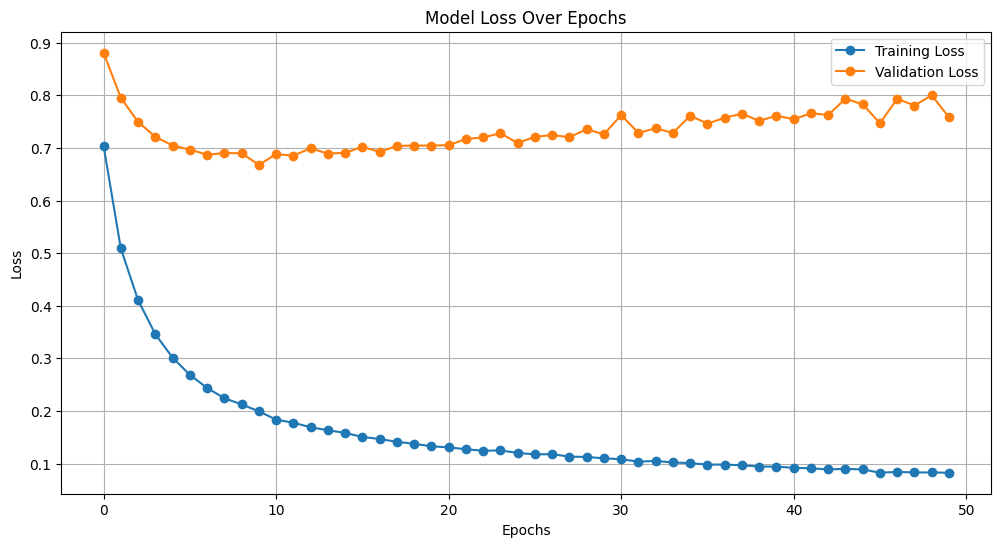

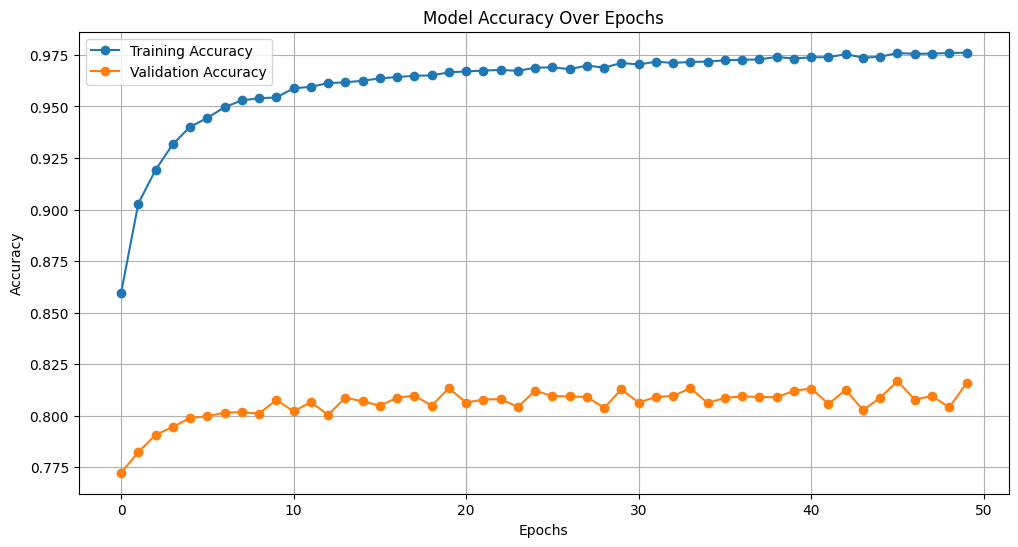

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

y_true = []
y_pred = []

for _ in range(len(os.listdir(test_image_folder)) // 32):
    images, labels = next(test_generator)
    predictions = final_model.predict(images)

    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━

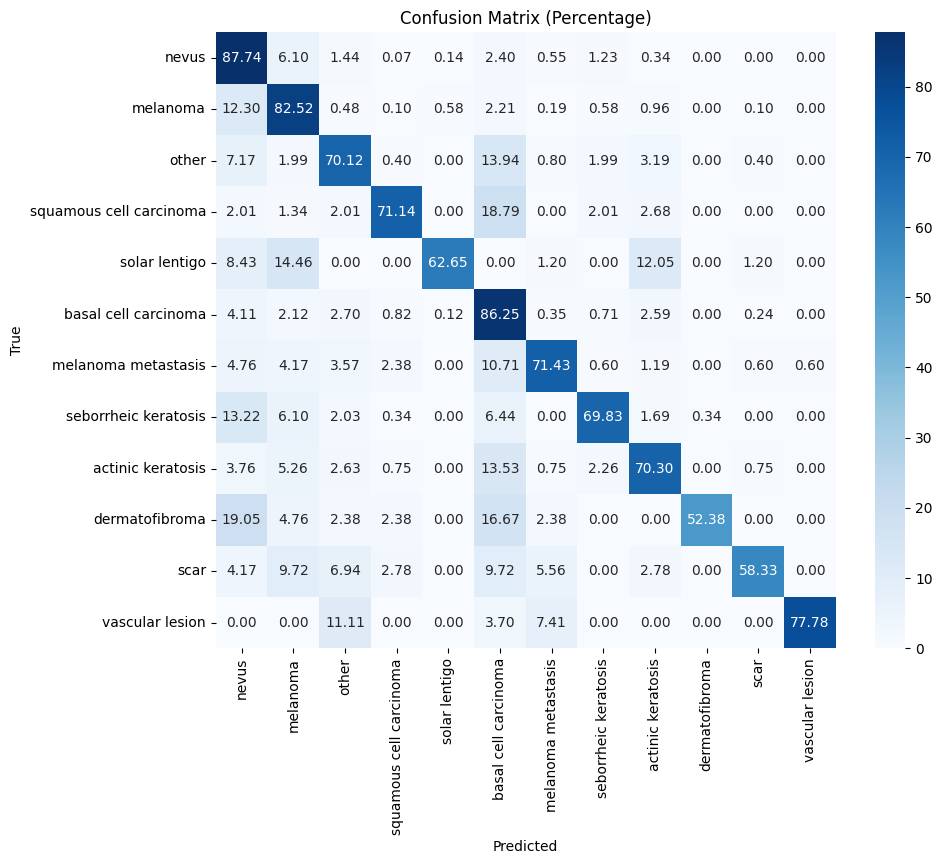

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(y_true, y_pred)

conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent * 100, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=diagnosis_mapping.keys(), yticklabels=diagnosis_mapping.keys())

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()


In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_true, y_pred)

class_report = classification_report(y_true, y_pred, target_names=diagnosis_mapping.keys(), output_dict=True)

print("Class-wise Accuracy, Precision, Recall, and F1-Score:")
for class_name, metrics in class_report.items():
    if class_name not in ["accuracy", "macro avg", "weighted avg"]:
        print(f"\nClass: {class_name}")
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-Score: {metrics['f1-score']:.2f}")


Class-wise Accuracy, Precision, Recall, and F1-Score:

Class: nevus
  Precision: 0.83
  Recall: 0.88
  F1-Score: 0.85

Class: melanoma
  Precision: 0.83
  Recall: 0.83
  F1-Score: 0.83

Class: other
  Precision: 0.69
  Recall: 0.70
  F1-Score: 0.69

Class: squamous cell carcinoma
  Precision: 0.84
  Recall: 0.71
  F1-Score: 0.77

Class: solar lentigo
  Precision: 0.85
  Recall: 0.63
  F1-Score: 0.72

Class: basal cell carcinoma
  Precision: 0.78
  Recall: 0.86
  F1-Score: 0.82

Class: melanoma metastasis
  Precision: 0.83
  Recall: 0.71
  F1-Score: 0.77

Class: seborrheic keratosis
  Precision: 0.82
  Recall: 0.70
  F1-Score: 0.75

Class: actinic keratosis
  Precision: 0.73
  Recall: 0.70
  F1-Score: 0.72

Class: dermatofibroma
  Precision: 0.96
  Recall: 0.52
  F1-Score: 0.68

Class: scar
  Precision: 0.84
  Recall: 0.58
  F1-Score: 0.69

Class: vascular lesion
  Precision: 0.95
  Recall: 0.78
  F1-Score: 0.86


In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)

class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Accuracy per class:")
for idx, class_name in enumerate(diagnosis_mapping.keys()):
    print(f"{class_name}: {class_accuracies[idx]:.2f}")


Accuracy per class:
nevus: 0.88
melanoma: 0.83
other: 0.70
squamous cell carcinoma: 0.71
solar lentigo: 0.63
basal cell carcinoma: 0.86
melanoma metastasis: 0.71
seborrheic keratosis: 0.70
actinic keratosis: 0.70
dermatofibroma: 0.52
scar: 0.58
vascular lesion: 0.78


In [30]:
# Save only model weights
# final_model.save_weights(save_model_path)
